In [ ]:
# Dense Neural Networks works better on flattened neural inputs & the don't capture the spatial features of the images
# CNN works better on image recognition and processing tasks

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
(train_images, _), (_,_) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape # there are 60000 images of dimension 28x28 consisting of grayscale image(1 channel)

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

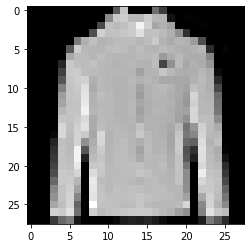

In [ ]:
plt.imshow(train_images[56782,:,:] ,cmap='gray')

In [ ]:
train_images.shape[0]

60000

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5
train_images.shape # batch_size, height, width and no. of channels=1

(60000, 28, 28, 1)

In [ ]:
buffer_size = 60000
batch_size = 128

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7 * 7 * 256, input_shape=(100, ))) 
  model.add(layers.BatchNormalization()) # set to mean=0 and var=1
  model.add(layers.ReLU())
  model.add(layers.Reshape((7,7,256)))

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(1,(5,5), strides=(2,2), padding='same', activation = 'tanh'))

  return model

In [ ]:
generator = generator_model()
generator.summary() # high level summary of our generator network architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

(1, 28, 28, 1)


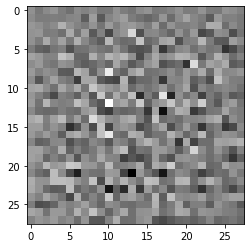

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0,:,:,0], cmap='gray') # This image is just the noise

In [ ]:
# DISCRIMINATOR MODEL
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  
  return model

In [ ]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                      

In [ ]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.5004278]], shape=(1, 1), dtype=float32)


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = bce(tf.ones_like(real_output), real_output) 
  fake_loss = bce(tf.zeros_like(fake_output), fake_output) 
  total_loss = real_loss + fake_loss 
  return total_loss

In [ ]:
def generator_loss(fake_output):
  gen_loss = bce(tf.ones_like(fake_output), fake_output)
  return gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_and_plot_images(model, epoch , test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(8,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i+1)
    pred = (predictions[i, :, :, 0] + 1) * 127.5
    pred = np.array(pred)
    plt.imshow(pred.astype(np.uint8), cmap = 'gray')
    plt.axis('off')

  plt.savefig('image_at_epch_{:04d}.png'.format(epoch))
  plt.show()

# This will allow us to see how the generator improves over time.

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)    

  gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))


In [ ]:
def train(dataset, epochs):
  
  # list used for plotting
  gen_loss_list = [] 
  disc_loss_list = []

  # list used for accuracies score for the discriminator on real and fake data
  real_score_list = []
  fake_score_list = []

  # run for no. of epochs
  # for every epoch we'll split our real training dataset into batches and feed
  # in this data one batch at a time
  for epoch in tqdm(range(epochs)):
    start = time.time()
    num_batches = len(dataset)

    print(f'Training started with epoch {epoch + 1} with {num_batches} batches...')

    # Variables for total generator loss and the total discriminator loss
    total_gen_loss = 0
    total_disc_loss = 0

    # for every batch of the i/p data, the train_step will train the generator and the discriminator
    # on this batch of data.
    # The train_step function - generates fake images, feeds real as well as fake images to the 
    # discriminator, computes loss, computes gradients for both of our adversary N/W, and updates
    # both the model parameters
    for batch in dataset:
      generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss

    # Computer the average loss of the epoch, this mean values will be print out on screen
    mean_gen_loss = total_gen_loss / num_batches
    mean_disc_loss = total_disc_loss / num_batches

    print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
          (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))
    
    # generate_and_plot_images function is invokes to feed in our test noise sample, i.e. seed
    # That is our seed and see what is the o/p looks like after the current epoch of training
    generate_and_plot_images(generator, epoch + 1, seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches...
Losses after epoch     1: generator 2.115, discriminator 0.418, real_score 83.35%, fake_score 16.97%


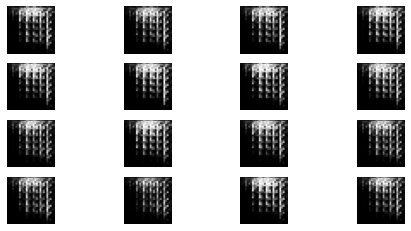

  2%|▏         | 1/50 [00:17<14:05, 17.25s/it]

Time for epoch 1 is 17.24994945526123 sec
Training started with epoch 2 with 469 batches...
Losses after epoch     2: generator 1.538, discriminator 0.784, real_score 74.07%, fake_score 28.92%


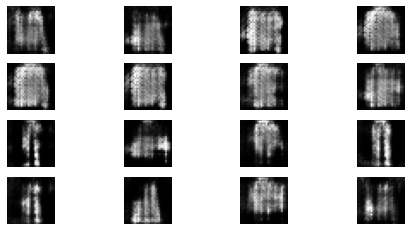

  4%|▍         | 2/50 [00:28<11:03, 13.82s/it]

Time for epoch 2 is 11.423513650894165 sec
Training started with epoch 3 with 469 batches...
Losses after epoch     3: generator 1.158, discriminator 1.004, real_score 70.05%, fake_score 38.66%


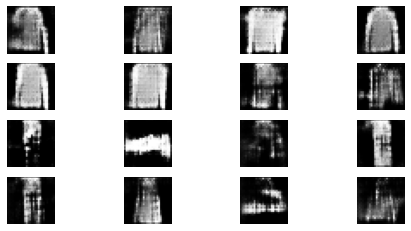

  6%|▌         | 3/50 [00:40<10:05, 12.89s/it]

Time for epoch 3 is 11.770329475402832 sec
Training started with epoch 4 with 469 batches...
Losses after epoch     4: generator 1.052, discriminator 1.168, real_score 63.13%, fake_score 41.69%


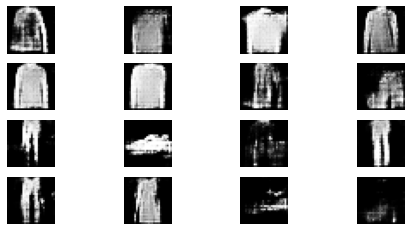

  8%|▊         | 4/50 [00:52<09:30, 12.40s/it]

Time for epoch 4 is 11.646485567092896 sec
Training started with epoch 5 with 469 batches...
Losses after epoch     5: generator 1.394, discriminator 1.468, real_score 43.14%, fake_score 31.57%


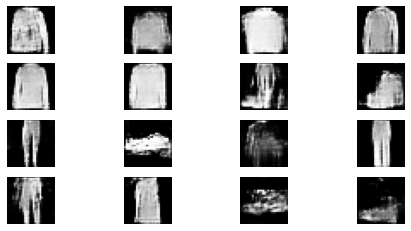

 10%|█         | 5/50 [01:03<09:04, 12.11s/it]

Time for epoch 5 is 11.580111980438232 sec
Training started with epoch 6 with 469 batches...
Losses after epoch     6: generator 0.943, discriminator 1.343, real_score 58.14%, fake_score 45.41%


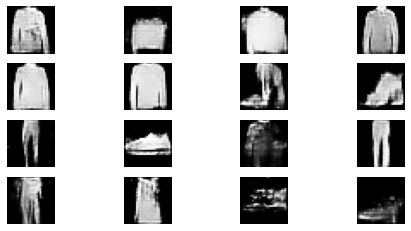

 12%|█▏        | 6/50 [01:15<08:43, 11.91s/it]

Time for epoch 6 is 11.509376764297485 sec
Training started with epoch 7 with 469 batches...
Losses after epoch     7: generator 1.224, discriminator 1.133, real_score 55.29%, fake_score 34.09%


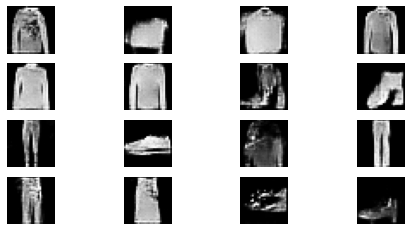

 14%|█▍        | 7/50 [01:26<08:25, 11.76s/it]

Time for epoch 7 is 11.450543880462646 sec
Training started with epoch 8 with 469 batches...
Losses after epoch     8: generator 1.422, discriminator 1.277, real_score 46.00%, fake_score 29.49%


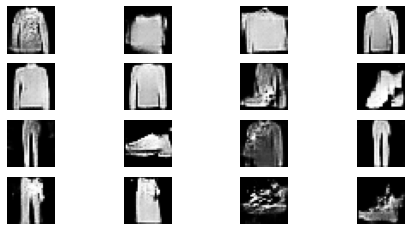

 16%|█▌        | 8/50 [01:38<08:12, 11.73s/it]

Time for epoch 8 is 11.659971714019775 sec
Training started with epoch 9 with 469 batches...
Losses after epoch     9: generator 1.115, discriminator 1.140, real_score 57.35%, fake_score 37.30%


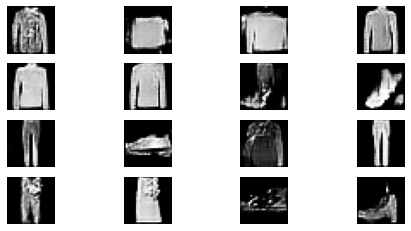

 18%|█▊        | 9/50 [01:49<07:58, 11.66s/it]

Time for epoch 9 is 11.50032639503479 sec
Training started with epoch 10 with 469 batches...
Losses after epoch    10: generator 0.865, discriminator 1.265, real_score 57.62%, fake_score 45.77%


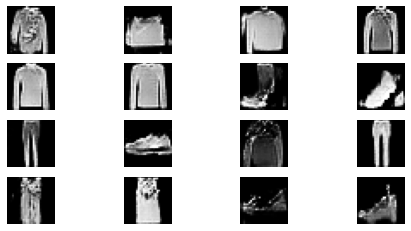

 20%|██        | 10/50 [02:01<07:45, 11.63s/it]

Time for epoch 10 is 11.566852331161499 sec
Training started with epoch 11 with 469 batches...
Losses after epoch    11: generator 0.939, discriminator 1.365, real_score 52.23%, fake_score 44.59%


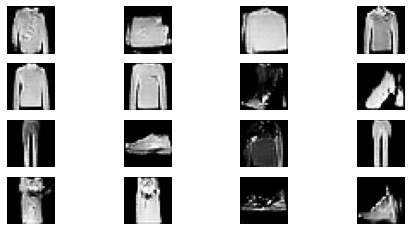

 22%|██▏       | 11/50 [02:12<07:31, 11.59s/it]

Time for epoch 11 is 11.484079122543335 sec
Training started with epoch 12 with 469 batches...
Losses after epoch    12: generator 0.968, discriminator 1.204, real_score 58.83%, fake_score 42.37%


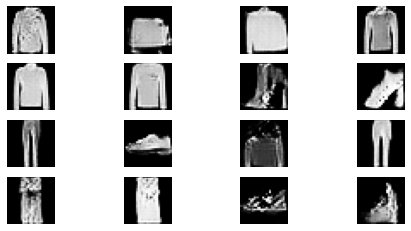

 24%|██▍       | 12/50 [02:24<07:22, 11.65s/it]

Time for epoch 12 is 11.773538827896118 sec
Training started with epoch 13 with 469 batches...
Losses after epoch    13: generator 0.903, discriminator 1.227, real_score 58.37%, fake_score 43.92%


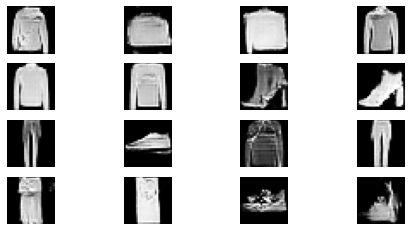

 26%|██▌       | 13/50 [02:36<07:09, 11.61s/it]

Time for epoch 13 is 11.517001867294312 sec
Training started with epoch 14 with 469 batches...
Losses after epoch    14: generator 1.006, discriminator 1.215, real_score 55.22%, fake_score 39.75%


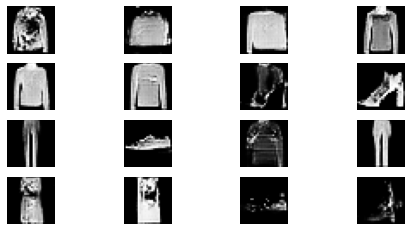

 28%|██▊       | 14/50 [02:47<06:56, 11.58s/it]

Time for epoch 14 is 11.496095418930054 sec
Training started with epoch 15 with 469 batches...
Losses after epoch    15: generator 0.886, discriminator 1.329, real_score 53.00%, fake_score 44.44%


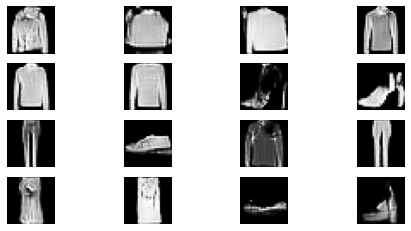

 30%|███       | 15/50 [02:59<06:44, 11.55s/it]

Time for epoch 15 is 11.492581367492676 sec
Training started with epoch 16 with 469 batches...
Losses after epoch    16: generator 0.851, discriminator 1.243, real_score 57.86%, fake_score 45.56%


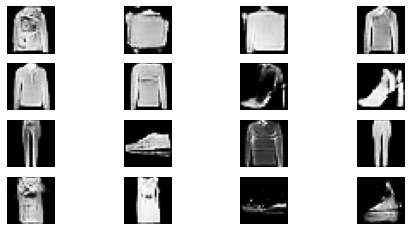

 32%|███▏      | 16/50 [03:10<06:31, 11.53s/it]

Time for epoch 16 is 11.456026315689087 sec
Training started with epoch 17 with 469 batches...
Losses after epoch    17: generator 0.816, discriminator 1.306, real_score 55.70%, fake_score 46.84%


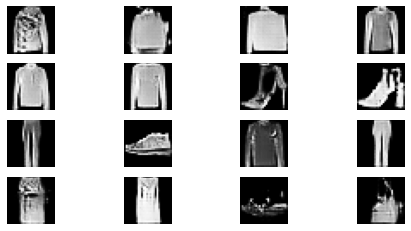

 34%|███▍      | 17/50 [03:22<06:22, 11.59s/it]

Time for epoch 17 is 11.731761693954468 sec
Training started with epoch 18 with 469 batches...
Losses after epoch    18: generator 0.904, discriminator 1.388, real_score 48.11%, fake_score 43.01%


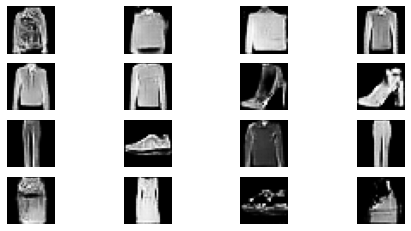

 36%|███▌      | 18/50 [03:33<06:09, 11.56s/it]

Time for epoch 18 is 11.493437051773071 sec
Training started with epoch 19 with 469 batches...
Losses after epoch    19: generator 0.801, discriminator 1.243, real_score 59.55%, fake_score 47.48%


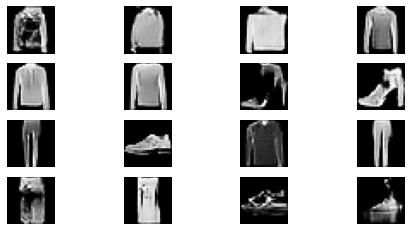

 38%|███▊      | 19/50 [03:45<05:57, 11.53s/it]

Time for epoch 19 is 11.464164972305298 sec
Training started with epoch 20 with 469 batches...
Losses after epoch    20: generator 0.885, discriminator 1.359, real_score 52.17%, fake_score 44.80%


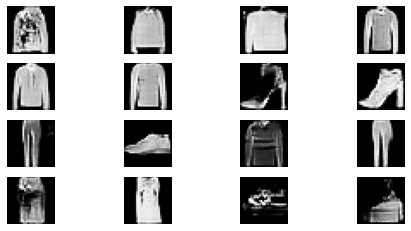

 40%|████      | 20/50 [03:56<05:46, 11.55s/it]

Time for epoch 20 is 11.570558309555054 sec
Training started with epoch 21 with 469 batches...
Losses after epoch    21: generator 0.860, discriminator 1.305, real_score 53.11%, fake_score 44.43%


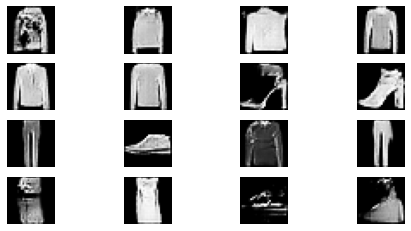

 42%|████▏     | 21/50 [04:08<05:34, 11.52s/it]

Time for epoch 21 is 11.4636812210083 sec
Training started with epoch 22 with 469 batches...
Losses after epoch    22: generator 0.782, discriminator 1.329, real_score 56.12%, fake_score 48.42%


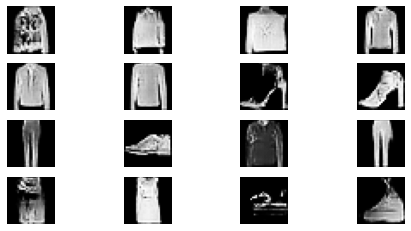

 44%|████▍     | 22/50 [04:20<05:24, 11.58s/it]

Time for epoch 22 is 11.715490818023682 sec
Training started with epoch 23 with 469 batches...
Losses after epoch    23: generator 0.832, discriminator 1.257, real_score 56.07%, fake_score 45.49%


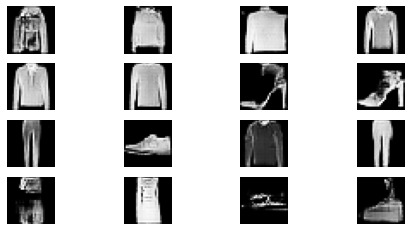

 46%|████▌     | 23/50 [04:31<05:11, 11.55s/it]

Time for epoch 23 is 11.457884788513184 sec
Training started with epoch 24 with 469 batches...
Losses after epoch    24: generator 0.751, discriminator 1.291, real_score 57.68%, fake_score 48.97%


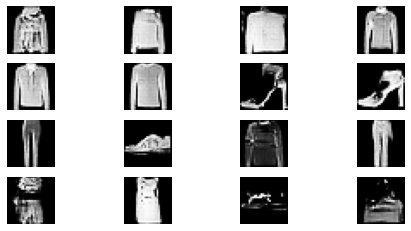

 48%|████▊     | 24/50 [04:52<06:13, 14.38s/it]

Time for epoch 24 is 20.96574091911316 sec
Training started with epoch 25 with 469 batches...
Losses after epoch    25: generator 0.804, discriminator 1.345, real_score 54.69%, fake_score 47.57%


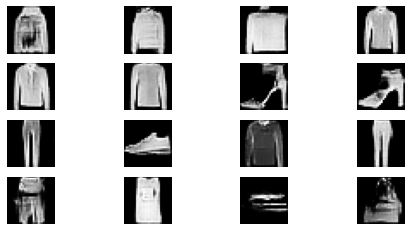

 50%|█████     | 25/50 [05:04<05:37, 13.51s/it]

Time for epoch 25 is 11.482334613800049 sec
Training started with epoch 26 with 469 batches...
Losses after epoch    26: generator 0.956, discriminator 1.257, real_score 51.32%, fake_score 40.51%


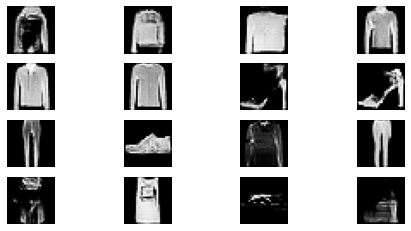

 52%|█████▏    | 26/50 [05:15<05:10, 12.93s/it]

Time for epoch 26 is 11.571441173553467 sec
Training started with epoch 27 with 469 batches...
Losses after epoch    27: generator 0.741, discriminator 1.371, real_score 55.04%, fake_score 49.57%


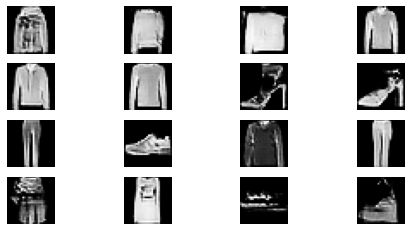

 54%|█████▍    | 27/50 [05:27<04:49, 12.61s/it]

Time for epoch 27 is 11.85170292854309 sec
Training started with epoch 28 with 469 batches...
Losses after epoch    28: generator 0.774, discriminator 1.337, real_score 53.18%, fake_score 47.81%


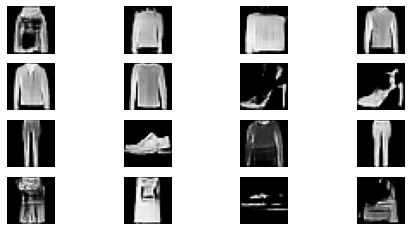

 56%|█████▌    | 28/50 [05:48<05:32, 15.11s/it]

Time for epoch 28 is 20.94028902053833 sec
Training started with epoch 29 with 469 batches...
Losses after epoch    29: generator 0.801, discriminator 1.317, real_score 53.65%, fake_score 46.73%


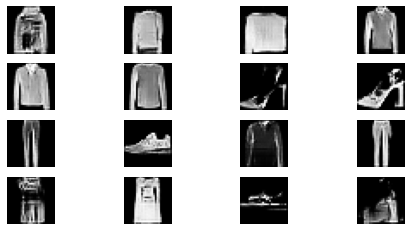

 58%|█████▊    | 29/50 [05:59<04:54, 14.01s/it]

Time for epoch 29 is 11.455003499984741 sec
Training started with epoch 30 with 469 batches...
Losses after epoch    30: generator 0.958, discriminator 1.245, real_score 52.53%, fake_score 40.91%


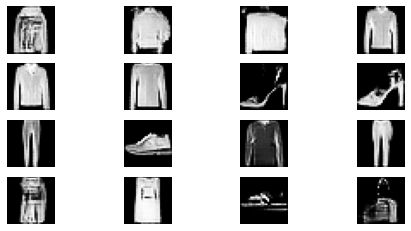

 60%|██████    | 30/50 [06:11<04:25, 13.30s/it]

Time for epoch 30 is 11.617143154144287 sec
Training started with epoch 31 with 469 batches...
Losses after epoch    31: generator 0.779, discriminator 1.302, real_score 56.03%, fake_score 47.70%


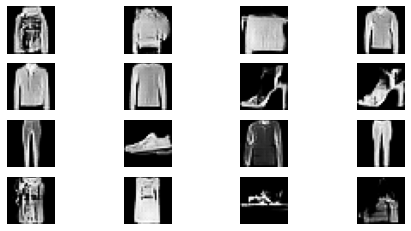

 62%|██████▏   | 31/50 [06:23<04:04, 12.86s/it]

Time for epoch 31 is 11.856950283050537 sec
Training started with epoch 32 with 469 batches...
Losses after epoch    32: generator 0.925, discriminator 1.248, real_score 53.29%, fake_score 41.80%


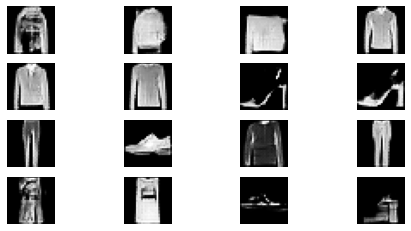

 64%|██████▍   | 32/50 [06:34<03:44, 12.48s/it]

Time for epoch 32 is 11.567112445831299 sec
Training started with epoch 33 with 469 batches...
Losses after epoch    33: generator 0.736, discriminator 1.358, real_score 54.83%, fake_score 49.64%


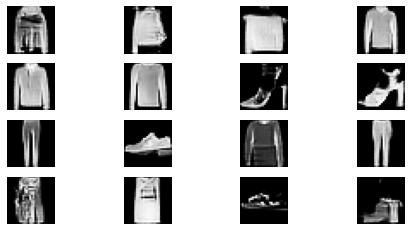

 66%|██████▌   | 33/50 [06:46<03:27, 12.18s/it]

Time for epoch 33 is 11.491028308868408 sec
Training started with epoch 34 with 469 batches...
Losses after epoch    34: generator 0.837, discriminator 1.357, real_score 50.79%, fake_score 45.17%


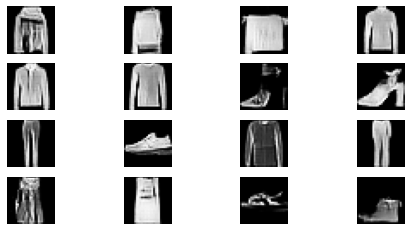

 68%|██████▊   | 34/50 [06:57<03:11, 11.96s/it]

Time for epoch 34 is 11.436137676239014 sec
Training started with epoch 35 with 469 batches...
Losses after epoch    35: generator 0.834, discriminator 1.351, real_score 50.18%, fake_score 45.08%


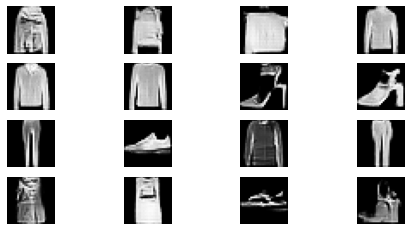

 70%|███████   | 35/50 [07:09<02:56, 11.80s/it]

Time for epoch 35 is 11.42332673072815 sec
Training started with epoch 36 with 469 batches...
Losses after epoch    36: generator 0.876, discriminator 1.231, real_score 55.23%, fake_score 43.69%


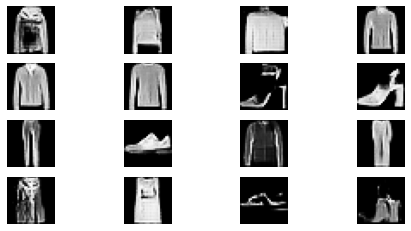

 72%|███████▏  | 36/50 [07:21<02:44, 11.77s/it]

Time for epoch 36 is 11.70714020729065 sec
Training started with epoch 37 with 469 batches...
Losses after epoch    37: generator 0.850, discriminator 1.307, real_score 51.64%, fake_score 44.45%


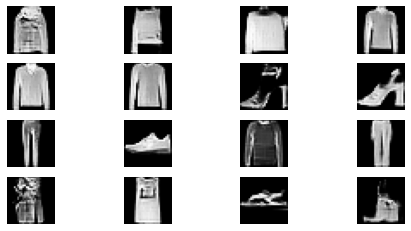

 74%|███████▍  | 37/50 [07:32<02:31, 11.68s/it]

Time for epoch 37 is 11.440842866897583 sec
Training started with epoch 38 with 469 batches...
Losses after epoch    38: generator 0.845, discriminator 1.328, real_score 51.65%, fake_score 44.96%


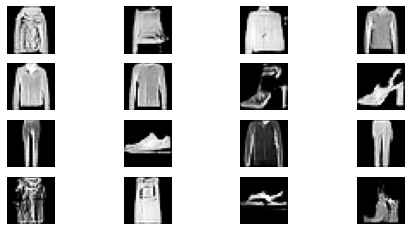

 76%|███████▌  | 38/50 [07:43<02:19, 11.62s/it]

Time for epoch 38 is 11.481849431991577 sec
Training started with epoch 39 with 469 batches...
Losses after epoch    39: generator 0.865, discriminator 1.304, real_score 51.13%, fake_score 43.57%


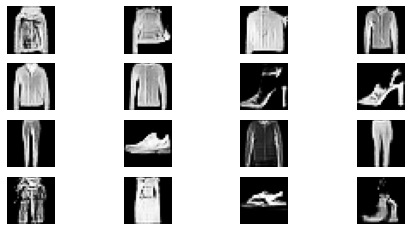

 78%|███████▊  | 39/50 [07:55<02:07, 11.58s/it]

Time for epoch 39 is 11.486486673355103 sec
Training started with epoch 40 with 469 batches...
Losses after epoch    40: generator 0.931, discriminator 1.338, real_score 48.22%, fake_score 41.74%


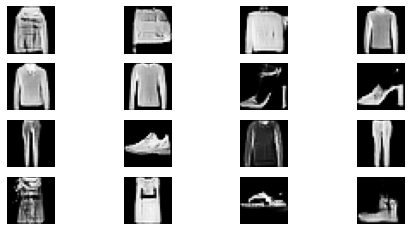

 80%|████████  | 40/50 [08:07<01:56, 11.66s/it]

Time for epoch 40 is 11.839463710784912 sec
Training started with epoch 41 with 469 batches...
Losses after epoch    41: generator 0.754, discriminator 1.343, real_score 54.50%, fake_score 48.86%


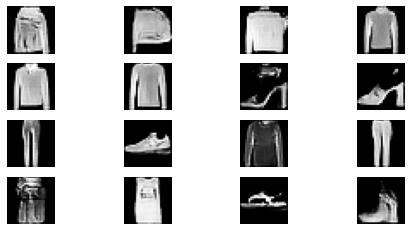

 82%|████████▏ | 41/50 [08:18<01:44, 11.61s/it]

Time for epoch 41 is 11.484877824783325 sec
Training started with epoch 42 with 469 batches...
Losses after epoch    42: generator 0.719, discriminator 1.343, real_score 55.92%, fake_score 50.44%


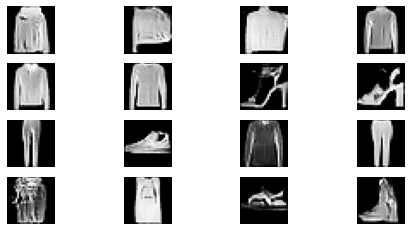

 84%|████████▍ | 42/50 [08:30<01:32, 11.57s/it]

Time for epoch 42 is 11.477890491485596 sec
Training started with epoch 43 with 469 batches...
Losses after epoch    43: generator 0.834, discriminator 1.272, real_score 53.71%, fake_score 45.01%


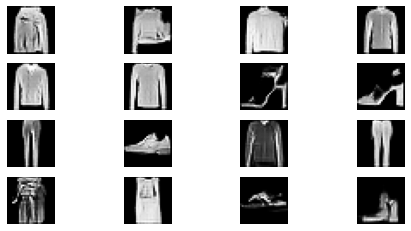

 86%|████████▌ | 43/50 [08:41<01:20, 11.54s/it]

Time for epoch 43 is 11.451074838638306 sec
Training started with epoch 44 with 469 batches...
Losses after epoch    44: generator 0.844, discriminator 1.363, real_score 50.36%, fake_score 45.32%


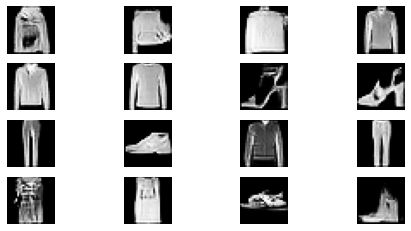

 88%|████████▊ | 44/50 [08:53<01:09, 11.52s/it]

Time for epoch 44 is 11.49368667602539 sec
Training started with epoch 45 with 469 batches...
Losses after epoch    45: generator 0.908, discriminator 1.302, real_score 50.35%, fake_score 42.30%


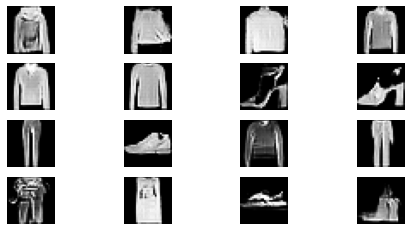

 90%|█████████ | 45/50 [09:04<00:57, 11.59s/it]

Time for epoch 45 is 11.748706340789795 sec
Training started with epoch 46 with 469 batches...
Losses after epoch    46: generator 0.800, discriminator 1.287, real_score 55.02%, fake_score 46.69%


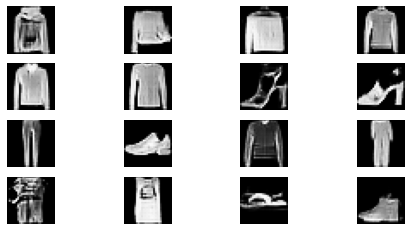

 92%|█████████▏| 46/50 [09:16<00:46, 11.57s/it]

Time for epoch 46 is 11.497959613800049 sec
Training started with epoch 47 with 469 batches...
Losses after epoch    47: generator 0.751, discriminator 1.411, real_score 51.35%, fake_score 49.07%


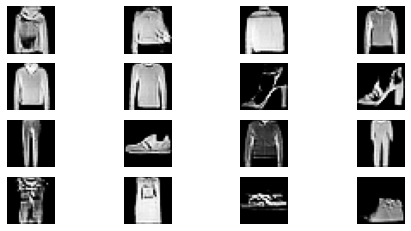

 94%|█████████▍| 47/50 [09:27<00:34, 11.55s/it]

Time for epoch 47 is 11.519799709320068 sec
Training started with epoch 48 with 469 batches...
Losses after epoch    48: generator 0.810, discriminator 1.335, real_score 51.95%, fake_score 46.27%


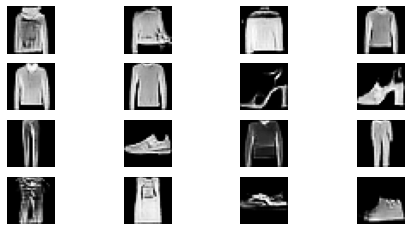

 96%|█████████▌| 48/50 [09:39<00:23, 11.53s/it]

Time for epoch 48 is 11.472837209701538 sec
Training started with epoch 49 with 469 batches...
Losses after epoch    49: generator 0.783, discriminator 1.286, real_score 55.27%, fake_score 47.31%


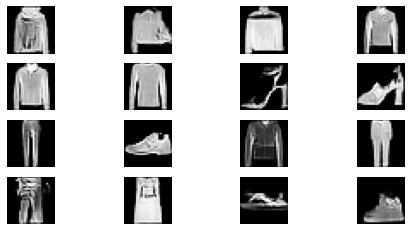

 98%|█████████▊| 49/50 [09:50<00:11, 11.51s/it]

Time for epoch 49 is 11.462568044662476 sec
Training started with epoch 50 with 469 batches...
Losses after epoch    50: generator 0.746, discriminator 1.373, real_score 52.71%, fake_score 49.07%


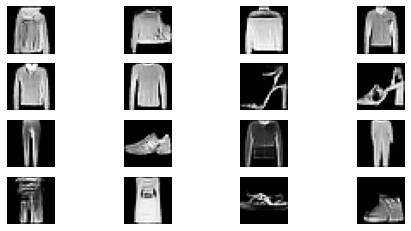

100%|██████████| 50/50 [10:02<00:00, 12.06s/it]

Time for epoch 50 is 11.832010984420776 sec


In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

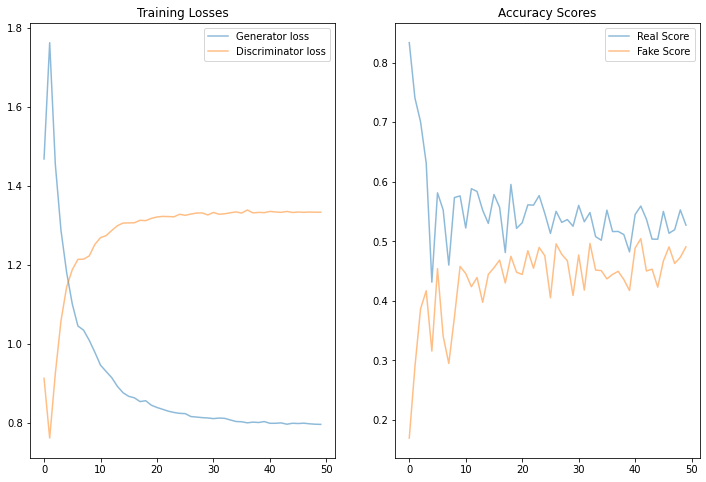

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha=0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real Score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake Score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()